# Business Problem

Apple has asked me to create a strong predictive model for detecting positive, negative, and neutral sentiment in tweets. They are primarily concerned with tweets about their company and products, but also want to know what people are saying about competitors like Google. My goals are:

1. Create a highly *accurate* classifier which can classify novel tweets as positive, negative, or neutral.
2. Explore what people are saying about Apple.

In [1]:
import re
import string
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
from nltk.collocations import BigramAssocMeasures
from nltk.tokenize.destructive import NLTKWordTokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    HashingVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
)

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, utils
from tools.modeling.vectorizers import Doc2Vectorizer, VaderVectorizer
from tools.modeling.transformers import ArrayForcer
from tools.modeling.wrappers import PandasWrapper
from tools.modeling.classification import diagnostics as diag
from tools.modeling.selection import sweep, load_results

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# RandomState for reproducibility
rando = np.random.RandomState(9547)

<IPython.core.display.Javascript object>

# Overview of Dataset

In [3]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

<IPython.core.display.Javascript object>

Looks like one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing this dataset. I'm going to rename those before I do anything else.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [5]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

text   object_of_emotion  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [6]:
cleaning.show_uniques(df)

<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [7]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [8]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':"'emotion' Value Counts"}, xlabel='Count'>

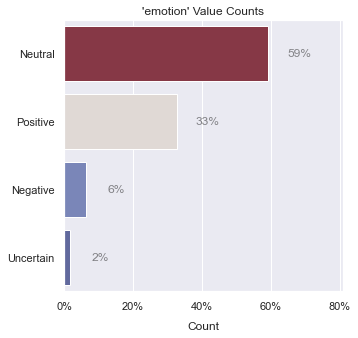

<IPython.core.display.Javascript object>

In [9]:
plotting.countplot(df["emotion"], normalize=True)

<AxesSubplot:title={'center':"'emotion' Value Counts"}, xlabel='Count'>

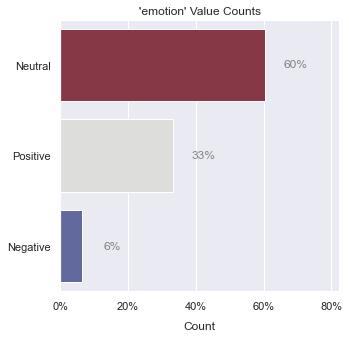

<IPython.core.display.Javascript object>

In [10]:
# Remove 'Uncertain' category
df.emotion.cat.remove_categories("Uncertain", inplace=True)
plotting.countplot(df.emotion, normalize=True)

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [11]:
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion  5802   63.81     9    0.10   22   0.24
emotion             156    1.72     3    0.03   22   0.24
text                  1    0.01  9065   99.69   22   0.24

<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [12]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion  5654   63.27     9    0.10   22   0.25
text                  0    0.00  8909   99.70   22   0.25
emotion               0    0.00     3    0.03   22   0.25

<IPython.core.display.Javascript object>

In [13]:
null_rows = cleaning.null_rows(df)
lang.readable_sample(null_rows["text"], random_state=rando)

|      | text                                                                                                                                    |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------|
| 5140 | RT @mention @mention New iPad Apps For Speech Therapy And Communication Are Showcased At #SXSW Conference {link} #sxswi #hcsm #sxswh    |
|  509 | Please RT Follow the next big #college social network @mention chance to win an #iPad at 7,000 followers #socialmedia #SXSW             |
| 4916 | millions of iPhone cases at #SXSW trade show but can any of them double as shuffleboard wax sprinklers? I think not. #fail (CC @mention |
| 6384 | RT @mention not launching any products at #SXSW but we're doing plenty else.  {link}                                                    |
|  790 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw&quot;                                             |
| 8793 | Google giving Social another go? {link} Google Circles, let's see what the guys at #SXSW make of it                                     |
| 8452 | @mention The unofficial #SXSW torrents are a great way to hear what you can expect this year {link}                                     |
| 3645 | U gotta fight for yr right to party &amp; to privacy ACLU/google #sxsw #partylikeits1986                                                |
|   61 | #futuremf @mention {link} spec for recipes on the web, now in google search: {link}  #sxsw                                              |
| 4081 | Hope people ask the tough questions. RT @mention Reminder: Android and Chrome TTS talk @mention 1 PM today!  {link}  #sxsw              |

<IPython.core.display.Javascript object>

Looks like some of the NaN values don't line up with the 'Neutral' category. Also, it's important to note that some retweets, e.g. 64, 68, do have sentimental content beyond that of the original tweet.

In [14]:
emotion_without_object = null_rows.loc[null_rows.emotion != "Neutral"]

# Delete variable
del null_rows

display(emotion_without_object.head(), emotion_without_object.shape)

text object_of_emotion  \
46   Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...               NaN   
64   Again? RT @mention Line at the Apple store is ...               NaN   
68   Boooo! RT @mention Flipboard is developing an ...               NaN   
103  Know that &quot;dataviz&quot; translates to &q...               NaN   
112  Spark for #android is up for a #teamandroid aw...               NaN   

      emotion  
46   Positive  
64   Negative  
68   Negative  
103  Negative  
112  Positive

(357, 3)

<IPython.core.display.Javascript object>

In [15]:
lang.readable_sample(
    emotion_without_object.groupby("emotion").get_group("Positive").text,
    random_state=rando,
)

|      | text                                                                                                                                                  |
|-----:|:------------------------------------------------------------------------------------------------------------------------------------------------------|
| 3353 | Whoohoo! Got it! ;) RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW (cont) {link}                            |
| 3928 | dancing with myself at google 80s party.... ain't that the truth! need my girl @mention up in this joint #SXSW {link}                                 |
|  783 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw rt @mention via @mention                                        |
| 1365 | @mention - re: &quot;lack of #SXSW newsworthy announcements&quot;. Unless you count Google Circles. :) #googlecircles                                 |
| 5307 | RT @mention #SXSW News: Apple is getting into the music business? New device called an &quot;iPod&quot;. Like a compact disc player without the disk. |
| 2447 | Near Field Communication already here on android phones. #SXSW #bemyneighbor                                                                          |
| 7530 | #spiltbeer consequences of drunk techies #sxsw let's see what android has to offer compared to this.                                                  |
| 5965 | RT @mention Having fun w/ @mention new Check-In's feature on iPhone | See @mention latest article &quot;Roll your own 4square&quot; {link} #SXSW      |
| 3442 | Back in the big apple!  Need to wean off my new foursquare addiction thanks to #sxsw and @mention Do people really care where I am? Nah               |
| 3780 | FYI @mention is working on an iPhone app, looking to release it this summer, hopefully. #SXSW #flipboard                                              |

<IPython.core.display.Javascript object>

In [16]:
# Create regex for finding each brand
re_apple = r"ipad\d?\s*app|ipad\d?|iphone\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find all brand/product name occurrences for each brand
findings = lang.locate_patterns(
    re_apple,
    re_google,
    strings=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

google         122
ipad            98
apple           76
iphone          57
ipad2           26
android         19
iphone app       8
ipad app         4
android app      1
ipad1            1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [17]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

original   match  score
5401    ipad2    iPad     89
3179    ipad2    iPad     89
8149    ipad2    iPad     89
6309    ipad2    iPad     89
3710    ipad2    iPad     89
...       ...     ...    ...
3224     ipad    iPad    100
3179     ipad    iPad    100
3134   google  Google    100
3055     ipad    iPad    100
9054     ipad    iPad    100

[412 rows x 3 columns]

<IPython.core.display.Javascript object>

In [18]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=rando)

text object_of_emotion  \
598   CNNMoney: Got a craving? #SXSW minds created a...            iPhone   
5401  RT @mention Anyone at #sxsw want to make a qui...              iPad   
5212  RT @mention #Apple saves #SXSW, set to open po...             Apple   
639   Catch 22��_ I mean iPad 2 at #SXSW - {link} #a...              iPad   
5586  RT @mention Buying iPad2? Turn in ur iPad1, Ap...              iPad   
8898  @mention What's the wait time lookin like? The...             Apple   
6371  RT @mention Nice! @mention just told me @menti...              iPad   
7680  Google (tries again) to launch a new social ne...            Google   
1813  3rd time a charm? All about privacy! RT @menti...            Google   
1284  Trying to update software (4.0) on iPhone to d...            iPhone   

       emotion  
598   Positive  
5401  Positive  
5212  Positive  
639   Positive  
5586  Positive  
8898  Positive  
6371  Positive  
7680  Negative  
1813  Positive  
1284  Negative

<IPython.core.display.Javascript object>

In [19]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

In [20]:
object_without_emotion = df.loc[
    (df.emotion == "Neutral") & df.object_of_emotion.notnull()
]
display(object_without_emotion.head(), object_without_emotion.shape)

text     object_of_emotion  \
63   #Smile RT @mention I think Apple's &quot;pop-u...                 Apple   
265  The #SXSW Apple &quot;pop-up&quot; store was n...                 Apple   
317  I arrived at #sxsw and my @mention issue hasn'...               iOS App   
558  haha. the google &quot;Party like it's 1986&qu...                Google   
588  Diller on Google TV: &quot;The first product w...  Other Google Product   

     emotion  
63   Neutral  
265  Neutral  
317  Neutral  
558  Neutral  
588  Neutral

(91, 3)

<IPython.core.display.Javascript object>

Tweet 6517 seems clearly negative to me, and 7137 seems kind of sardonic. 2666 seems weakly positive. 8647, 5696, 7521, 668, and 265 don't seem to express an emotion toward a brand or product. Since most of them seem neutral to me, and that's consistent with their 'Neutral' label, I'm going to keep them that way.

In [21]:
lang.readable_sample(object_without_emotion["text"], random_state=rando)

|      | text                                                                                                                                                       |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| 6127 | RT @mention In iPad Design Headaches: Take Two Tablets, Call Me in the AM panel - excited to hear @mention live! #sxsw                                     |
| 8271 | Google Hot Pot - what the whattt pot....#SXSW                                                                                                              |
| 1628 | @mention @mention Similarily, Tweetcaster for Android lets you zip tweets w annoying hash tags, like #sxsw                                                 |
| 6517 | RT @mention RT @mention Best thing I've heard this weekend at #SXSW &quot;I gave my iPad 2 money to #Japan relief. I don't need an iPad 2.&quot; (@mention |
| 8849 | We can't wait to give an iPad to someone at #sxsw. Want in? Just head to www.pep.jobs/upc to enter. (must be present to win)                               |
| 3011 | #iPad interface/controls should be at the top, mobile controls at the bottom. #tapworthy #sxsw                                                             |
|  787 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw�۝ @mention                                                           |
| 4826 | Talking to a 15 year old iPhone developer genius who came to SXSW with his proud dad. #SXSW @mention BD Riley's Irish Pub {link}                           |
| 1276 | Apple has two Austin-area retail locations but in anticipation of all the gadget ...  #ipad #sxsw #gadgets {link}                                          |
| 7173 | ipad is not a game changer just a new game, its a about multiplicity and options not either or, but someone has to p[ay for content! #sxsw                 |

<IPython.core.display.Javascript object>

In [22]:
# Set object to null where emotion is neutral
df.loc[object_without_emotion.index, "object_of_emotion"] = np.nan

# Ensure that 'Neutral' rows line up with 'NaN' rows
(df["emotion"] == "Neutral").equals(df["object_of_emotion"].isnull())

True

<IPython.core.display.Javascript object>

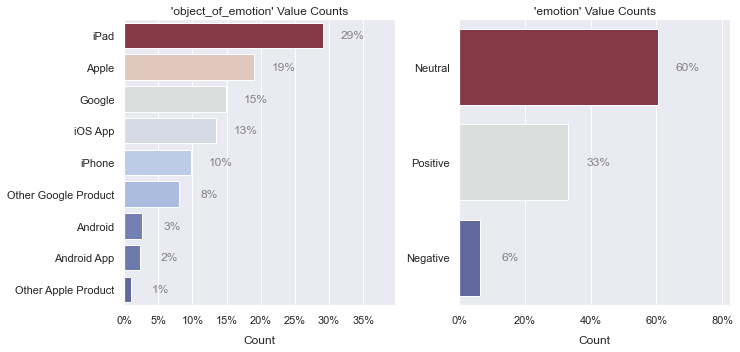

<IPython.core.display.Javascript object>

In [23]:
fig = plotting.countplot(df.select_dtypes("category"), normalize=1)

## Duplicates
There are $22$ duplicate rows, and even more when only the text is considered. I don't want to get rid of all retweets, but I do want to get rid of those which don't have novel content.

In [24]:
cleaning.dup_rows(df.text).sort_values()

3962    #SXSW is just starting, #CTIA is around the co...
468        Before It Even Begins, Apple Wins #SXSW {link}
2559    Counting down the days to #sxsw plus strong Ca...
776     Google to Launch Major New Social Network Call...
8483    I just noticed DST is coming this weekend. How...
2232    Marissa Mayer: Google Will Connect the Digital...
8747    Need to buy an iPad2 while I'm in Austin at #s...
4897    Oh. My. God. The #SXSW app for iPad is pure, u...
5882    RT @mention Google to Launch Major New Social ...
5884    RT @mention Google to Launch Major New Social ...
5883    RT @mention Google to Launch Major New Social ...
5881    RT @mention Google to Launch Major New Social ...
5885    RT @mention Google to Launch Major New Social ...
6299    RT @mention Marissa Mayer: Google Will Connect...
6297    RT @mention Marissa Mayer: Google Will Connect...
6295    RT @mention Marissa Mayer: Google Will Connect...
6300    RT @mention Marissa Mayer: Google Will Connect...
6298    RT @me

<IPython.core.display.Javascript object>

I filter the text by removing occurrences of 'RT' and then check for duplicates. This should get rid of retweets which are just copies of original tweets in the dataset.

In [25]:
dups = df.text.str.replace(r"\s*RT\s*", "", regex=True).duplicated()
df = df.loc[~dups]
dups.sum()

33

<IPython.core.display.Javascript object>

In [26]:
funcs = [
    lang.lowercase,
    lang.strip_short,
    partial(lang.strip_punct, exclude="!?@#"),
    lang.strip_multiwhite,
    lang.strip_numeric,
    lang.strip_non_alphanum,
    lang.split_alphanum,
    lang.uni2ascii,
    lang.stem_text,
    lang.strip_handles,
    lang.limit_repeats,
    lang.wordnet_lemmatize,
    lang.stem_text,
    lang.mark_pos,
    lang.mark_negation,
]

func_names = utils.get_func_name(funcs)
funcs = pd.Series(dict(zip(func_names, funcs)))
funcs

lowercase                    <function lowercase at 0x000001ACEFB45310>
strip_short                <function strip_short at 0x000001ACEFB453A0>
strip_punct           functools.partial(<function strip_punct at 0x0...
strip_multiwhite      <function strip_multiwhite at 0x000001ACEFB45430>
strip_numeric            <function strip_numeric at 0x000001ACEFB454C0>
strip_non_alphanum    <function strip_non_alphanum at 0x000001ACEFB4...
split_alphanum          <function split_alphanum at 0x000001ACEFB455E0>
uni2ascii                    <function uni2ascii at 0x000001ACEFB45C10>
stem_text                    <function stem_text at 0x000001ACEFB459D0>
strip_handles            <function strip_handles at 0x000001ACEFB45A60>
limit_repeats            <function limit_repeats at 0x000001ACEFB45670>
wordnet_lemmatize     <function wordnet_lemmatize at 0x000001ACEFB4D...
mark_pos                      <function mark_pos at 0x000001ACEFB4D040>
mark_negation            <function mark_negation at 0x000001ACEF

<IPython.core.display.Javascript object>

In [27]:
filts = [
    "lowercase",
    "uni2ascii",
    "strip_handles",
    "wordnet_lemmatize",
    "strip_punct",
    "split_alphanum",
    "strip_short",
    "limit_repeats",
    "strip_multiwhite",
]

filts = lang.make_preprocessor(funcs.loc[filts].to_list())
filts

functools.partial(<function chain_funcs at 0x000001ACEFB49700>, funcs=[<function lowercase at 0x000001ACEFB45310>, <function uni2ascii at 0x000001ACEFB45C10>, <function strip_handles at 0x000001ACEFB45A60>, <function wordnet_lemmatize at 0x000001ACEFB4D790>, functools.partial(<function strip_punct at 0x000001ACEFB45CA0>, exclude='!?@#'), <function split_alphanum at 0x000001ACEFB455E0>, <function strip_short at 0x000001ACEFB453A0>, <function limit_repeats at 0x000001ACEFB45670>, <function strip_multiwhite at 0x000001ACEFB45430>])

<IPython.core.display.Javascript object>

In [28]:
df["clean_text"] = filts(df["text"])
df.head()

text object_of_emotion  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...            iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...           iOS App   
2  @swonderlin Can not wait for #iPad 2 also. The...              iPad   
3  @sxsw I hope this year's festival isn't as cra...           iOS App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...            Google   

    emotion                                         clean_text  
0  Negative  have iphone after tweet #rise austin dead! nee...  
1  Positive  know about? awesome ipad iphone app that you l...  
2  Positive  cannot wait for #ipad also they should sale th...  
3  Negative  hope this year festival ben crashy this year i...  
4  Positive  great stuff fri #sxsw marissa mayer google tim...

<IPython.core.display.Javascript object>

In [29]:
re_brand = fr"{re_apple}|{re_google}"
regex_brands = lang.locate_patterns(re_brand, strings=df.clean_text)
regex_brands = utils.implode(regex_brands).reindex_like(df)
df["brand_terms"] = regex_brands
del regex_brands
df["brand_terms"].head()

0              [iphone]
1    [ipad, iphone app]
2                [ipad]
3          [iphone app]
4              [google]
Name: brand_terms, dtype: object

<IPython.core.display.Javascript object>

In [30]:
df["tokens"] = df["clean_text"].map(nltk.casual_tokenize)
df["tokens"].head()

0    [have, iphone, after, tweet, #rise, austin, de...
1    [know, about, ?, awesome, ipad, iphone, app, t...
2    [cannot, wait, for, #ipad, also, they, should,...
3    [hope, this, year, festival, ben, crashy, this...
4    [great, stuff, fri, #sxsw, marissa, mayer, goo...
Name: tokens, dtype: object

<IPython.core.display.Javascript object>

In [31]:
df["tagged"] = df["text"].map(
    partial(lang.tokenize_tag, tokenizer=nltk.casual_tokenize)
)
df["tagged"].head()

0    [(., .), (@wesley83, NN), (I, PRP), (have, VBP...
1    [(@jessedee, NN), (Know, NNP), (about, IN), (@...
2    [(@swonderlin, NNS), (Can, MD), (not, RB), (wa...
3    [(@sxsw, NN), (I, PRP), (hope, VBP), (this, DT...
4    [(@sxtxstate, JJ), (great, JJ), (stuff, NN), (...
Name: tagged, dtype: object

<IPython.core.display.Javascript object>

In [32]:
df["pos_tags"] = utils.implode(df["tagged"].explode().map(itemgetter(1), "ignore"))
df["pos_tags"].head()

0    [., NN, PRP, VBP, DT, CD, NN, ., IN, CD, NN, N...
1    [NN, NNP, IN, NNP, ., NNP, NN, NNP, NN, NN, WD...
2    [NNS, MD, RB, VB, IN, JJ, CD, RB, ., PRP, MD, ...
3    [NN, PRP, VBP, DT, NN, NN, NN, RB, JJ, IN, DT,...
4    [JJ, JJ, NN, IN, NNP, NN, :, NNP, NNP, (, NNP,...
Name: pos_tags, dtype: object

<IPython.core.display.Javascript object>

In [33]:
df["n_chars"] = df["text"].str.replace("\s+", "", regex=True).map(len)
df["n_words"] = df["text"].map(nltk.casual_tokenize).map(len)
df["avg_word_len"] = df["n_chars"] / df["n_words"]
df[["n_chars", "n_words", "avg_word_len"]]

n_chars  n_words  avg_word_len
0         104       29      3.586207
1         118       26      4.538462
2          65       17      3.823529
3          68       16      4.250000
4         115       27      4.259259
...       ...      ...           ...
9088       26        7      3.714286
9089      107       22      4.863636
9090      127       27      4.703704
9091      117       25      4.680000
9092       89       41      2.170732

[8879 rows x 3 columns]

<IPython.core.display.Javascript object>

In [46]:
df["ep_count"] = df["text"].str.count(r"\!")
df["qm_count"] = df["text"].str.count(r"\?")
df.head()

text object_of_emotion  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...            iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...           iOS App   
2  @swonderlin Can not wait for #iPad 2 also. The...              iPad   
3  @sxsw I hope this year's festival isn't as cra...           iOS App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...            Google   

    emotion                                         clean_text  \
0  Negative  have iphone after tweet #rise austin dead! nee...   
1  Positive  know about? awesome ipad iphone app that you l...   
2  Positive  cannot wait for #ipad also they should sale th...   
3  Negative  hope this year festival ben crashy this year i...   
4  Positive  great stuff fri #sxsw marissa mayer google tim...   

          brand_terms                                             tokens  \
0            [iphone]  [have, iphone, after, tweet, #rise, austin, de...   
1  [ipad, iphone app]  [know, about, ?, awesome, ipad, iphone, app, t...   
2              [ipad]  [cannot, wait, for, #ipad, also, they, should,...   
3        [iphone app]  [hope, this, year, festival, ben, crashy, this...   
4            [google]  [great, stuff, fri, #sxsw, marissa, mayer, goo...   

                                              tagged  \
0  [(., .), (@wesley83, NN), (I, PRP), (have, VBP...   
1  [(@jessedee, NN), (Know, NNP), (about, IN), (@...   
2  [(@swonderlin, NNS), (Can, MD), (not, RB), (wa...   
3  [(@sxsw, NN), (I, PRP), (hope, VBP), (this, DT...   
4  [(@sxtxstate, JJ), (great, JJ), (stuff, NN), (...   

                                            pos_tags  n_chars  n_words  \
0  [., NN, PRP, VBP, DT, CD, NN, ., IN, CD, NN, N...      104       29   
1  [NN, NNP, IN, NNP, ., NNP, NN, NNP, NN, NN, WD...      118       26   
2  [NNS, MD, RB, VB, IN, JJ, CD, RB, ., PRP, MD, ...       65       17   
3  [NN, PRP, VBP, DT, NN, NN, NN, RB, JJ, IN, DT,...       68       16   
4  [JJ, JJ, NN, IN, NNP, NN, :, NNP, NNP, (, NNP,...      115       27   

   avg_word_len  em_count  qm_count  ep_count  
0      3.586207         1         0         1  
1      4.538462         0         1         0  
2      3.823529         0         0         0  
3      4.250000         0         0         0  
4      4.259259         0         0         0

<IPython.core.display.Javascript object>

In [35]:
my_stop = ["sxsw", "#sxsw", "quot", "link"]
gensim_stop = list(STOPWORDS)
my_stop

['sxsw', '#sxsw', 'quot', 'link']

<IPython.core.display.Javascript object>

# Exploration

In [36]:
top_bigrams = lang.scored_bigrams(
    df.clean_text,
    measure="likelihood_ratio",
    tokenizer=nltk.casual_tokenize,
    preprocessor=lang.strip_punct,
    stopwords=my_stop,
    min_freq=25,
)
top_bigrams.head()

bigram
social network    4758.136856
network call      3295.272363
new social        3025.674836
call circle       2815.967978
apple store       2717.621589
Name: score, dtype: float64

<IPython.core.display.Javascript object>

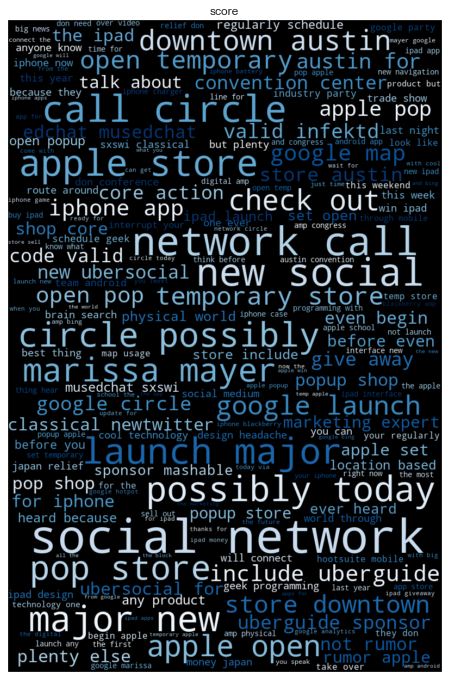

<IPython.core.display.Javascript object>

In [37]:
fig = plotting.wordclouds.wordcloud(
    top_bigrams,
    cmap="Blues",
    size=(8, 10),
    random_state=rando,
    prefer_horizontal=1,
)

In [38]:
mentions_apple = df.clean_text.loc[df.clean_text.str.contains("apple")]
mentions_google = df.clean_text.loc[df.clean_text.str.contains("google")]
mentions_google.head()

4     great stuff fri #sxsw marissa mayer google tim...
7     #sxsw just start #ctia around the corner and #...
13    get love this #sxsw google calendar feature to...
27    someone start #austin group google group pre #...
35    #sxsw oooh google launch major new social netw...
Name: clean_text, dtype: object

<IPython.core.display.Javascript object>

In [39]:
apple_quad = lang.scored_quadgrams(
    mentions_apple,
    measure="likelihood_ratio",
    tokenizer=nltk.word_tokenize,
    preprocessor=lang.strip_punct,
    stopwords=my_stop,
    min_freq=5,
)
google_quad = lang.scored_quadgrams(
    mentions_google,
    measure="likelihood_ratio",
    tokenizer=nltk.word_tokenize,
    preprocessor=lang.strip_punct,
    stopwords=my_stop,
    min_freq=5,
)
google_quad.head()

quadgram
new social network call       19692.111639
major new social network      19207.163991
social network call circle    17504.296828
launch major new social       16018.532152
launch new social network     14287.684795
Name: score, dtype: float64

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'Top Google Quadgrams')]

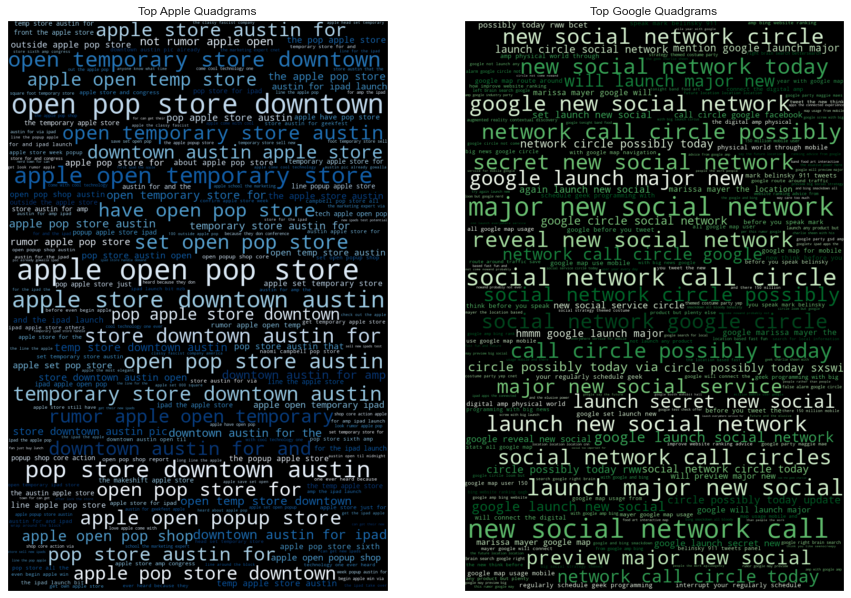

<IPython.core.display.Javascript object>

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 12))

plotting.wordclouds.wordcloud(
    apple_quad,
    cmap="Blues",
    random_state=rando,
    size=(8, 12),
    prefer_horizontal=1,
    ax=ax1,
)
plotting.wordclouds.wordcloud(
    google_quad,
    cmap="Greens",
    size=(8, 12),
    random_state=rando,
    prefer_horizontal=1,
    ax=ax2,
)
ax1.set(title="Top Apple Quadgrams")
ax2.set(title="Top Google Quadgrams")

In [41]:
del apple_quad, google_quad, mentions_apple, mentions_google

<IPython.core.display.Javascript object>

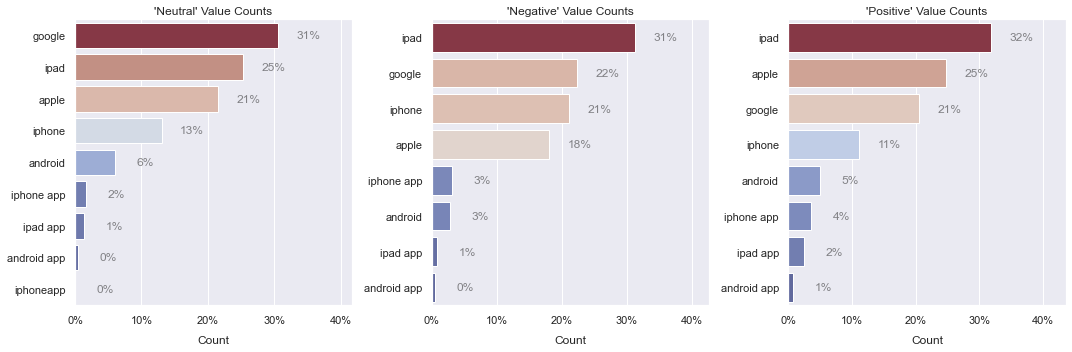

<IPython.core.display.Javascript object>

In [42]:
fig = plotting.countplot(
    df.explode("brand_terms").groupby("emotion")["brand_terms"],
    normalize=True,
)

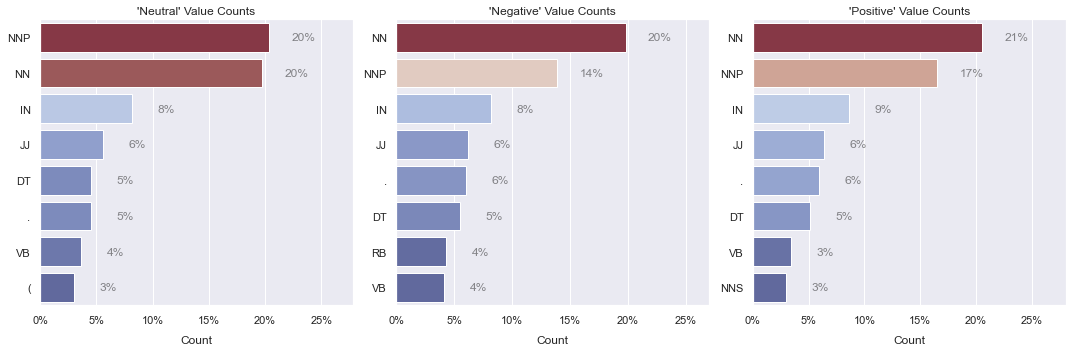

<IPython.core.display.Javascript object>

In [75]:
grouped = df.explode("pos_tags").groupby("emotion")["pos_tags"]

fig = plotting.countplot(grouped, normalize=True, topn=8)

In [43]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

<IPython.core.display.Javascript object>

In [70]:
emo_pal = dict(Negative="r", Neutral="gray", Positive="g")
emo_pal

{'Negative': 'r', 'Neutral': 'gray', 'Positive': 'g'}

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'Mean Number of Exclamation Points'),
 Text(0.5, 0, 'Emotion'),
 Text(0, 0.5, 'Count')]

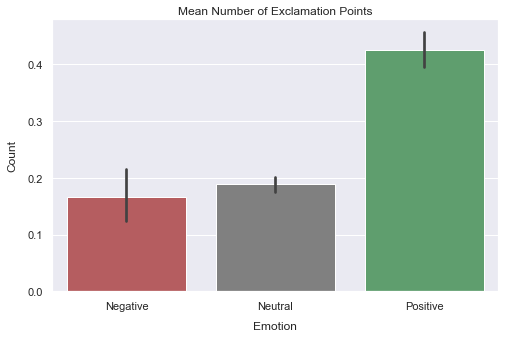

<IPython.core.display.Javascript object>

In [71]:
ax = plotting.barplot(
    data=df,
    x="emotion",
    y="ep_count",
    palette=emo_pal,
)
ax.set(
    title="Mean Number of Exclamation Points",
    xlabel="Emotion",
    ylabel="Count",
)

[Text(0.5, 1.0, 'Mean Number of Question Marks'),
 Text(0.5, 0, 'Emotion'),
 Text(0, 0.5, 'Count')]

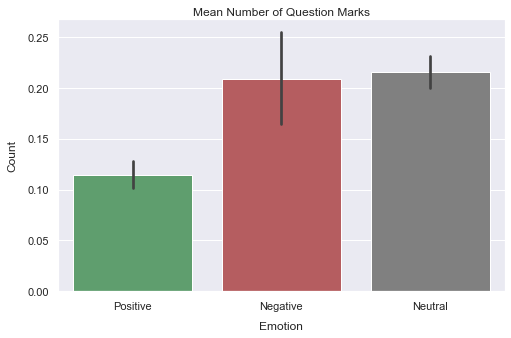

<IPython.core.display.Javascript object>

In [74]:
ax = plotting.barplot(
    data=df,
    x="emotion",
    y="qm_count",
    palette=emo_pal,
)
ax.set(
    title="Mean Number of Question Marks",
    xlabel="Emotion",
    ylabel="Count",
)

In [76]:
brand_docs = (
    pd.Series(df.groupby(["emotion", "object_of_emotion"]).groups)
    .map(lambda x: df.loc[x, "clean_text"])
    .map(lambda x: " ".join(x))
)

brand_docs = brand_docs.drop(index=np.nan, level=1)
brand_docs

Negative  Android                 they take away the lego pit but replace with r...
          Android App             beware the android #sxsw app for schedule comp...
          Apple                   again? line the apple store insane #sxsw cours...
          Google                  false alarm google circle not come nowand prob...
          Other Apple Product     mean itunes don work for don run apple softwar...
          Other Google Product    google launch major new social network call ci...
          iOS App                 hope this year festival ben crashy this year i...
          iPad                    attend ipad design headache #sxsw link ipad an...
          iPhone                  have iphone after tweet #rise austin dead! nee...
Positive  Android                 #sxsw just start #ctia around the corner and #...
          Android App             find amp start impromptu party #sxsw with http...
          Apple                   count down the day #sxsw plus strong canad

<IPython.core.display.Javascript object>

In [170]:
brand_stop = [
    "apple",
    "google",
    "android",
    "app",
    "ipad",
    "#apple",
    "#google",
    "#android",
    "iphone",
    "#iphone",
]

<IPython.core.display.Javascript object>

In [171]:
tfidf = TfidfVectorizer(
    tokenizer=nltk.casual_tokenize,
    stop_words=gensim_stop + my_stop + brand_stop,
    max_features=None,
    ngram_range=(1, 4),
    norm=None,
    min_df=0,
)
brand_vecs = tfidf.fit_transform(brand_docs.values)
brand_vecs = lang.frame_doc_vecs(
    brand_vecs,
    tfidf.vocabulary_,
    brand_docs.index,
).T
brand_vecs

Negative                                    \
                                 Android Android App      Apple     Google   
!                               2.108134    1.054067  12.648807  14.756941   
! !                             0.000000    0.000000   1.305382   2.610763   
! ! !                           0.000000    0.000000   0.000000   1.379490   
! ! ! !                         0.000000    0.000000   0.000000   0.000000   
! ! ! #austin                   0.000000    0.000000   0.000000   0.000000   
...                                  ...         ...        ...        ...   
zoom brushstroke #loveher pick  0.000000    0.000000   0.000000   0.000000   
zzzs                            0.000000    0.000000   0.000000   0.000000   
zzzs battery                    0.000000    0.000000   0.000000   0.000000   
zzzs battery life               0.000000    0.000000   0.000000   0.000000   
zzzs battery life popup         0.000000    0.000000   0.000000   0.000000   

                                                                         \
                               Other Apple Product Other Google Product   
!                                              0.0             6.324403   
! !                                            0.0             2.610763   
! ! !                                          0.0             1.379490   
! ! ! !                                        0.0             0.000000   
! ! ! #austin                                  0.0             0.000000   
...                                            ...                  ...   
zoom brushstroke #loveher pick                 0.0             0.000000   
zzzs                                           0.0             0.000000   
zzzs battery                                   0.0             0.000000   
zzzs battery life                              0.0             0.000000   
zzzs battery life popup                        0.0             0.000000   

                                                                  Positive  \
                                  iOS App       iPad     iPhone    Android   
!                               12.648807  12.648807  31.622017  40.054554   
! !                              3.916145   0.000000   2.610763   5.221527   
! ! !                            1.379490   0.000000   1.379490   1.379490   
! ! ! !                          0.000000   0.000000   0.000000   0.000000   
! ! ! #austin                    0.000000   0.000000   0.000000   0.000000   
...                                   ...        ...        ...        ...   
zoom brushstroke #loveher pick   0.000000   0.000000   0.000000   0.000000   
zzzs                             0.000000   0.000000   3.251292   0.000000   
zzzs battery                     0.000000   0.000000   3.251292   0.000000   
zzzs battery life                0.000000   0.000000   3.251292   0.000000   
zzzs battery life popup          0.000000   0.000000   3.251292   0.000000   

                                                                    \
                               Android App       Apple      Google   
!                                62.189966  176.029226  172.867024   
! !                               7.832290   15.664580   39.161449   
! ! !                             4.138469    4.138469   13.794896   
! ! ! !                           0.000000    0.000000    0.000000   
! ! ! #austin                     0.000000    0.000000    0.000000   
...                                    ...         ...         ...   
zoom brushstroke #loveher pick    0.000000    0.000000    0.000000   
zzzs                              0.000000    0.000000    0.000000   
zzzs battery                      0.000000    0.000000    0.000000   
zzzs battery life                 0.000000    0.000000    0.000000   
zzzs battery life popup           0.000000    0.000000    0.000000   

                                                                         \
                               Other App

<IPython.core.display.Javascript object>

In [172]:
# Swap column levels in order to plot pos and neg together
pair_vecs = brand_vecs.swaplevel(0, 1, axis=1).sort_index(level=0, axis=1)
pair_vecs

Android            Android App             \
                                Negative   Positive    Negative   Positive   
!                               2.108134  40.054554    1.054067  62.189966   
! !                             0.000000   5.221527    0.000000   7.832290   
! ! !                           0.000000   1.379490    0.000000   4.138469   
! ! ! !                         0.000000   0.000000    0.000000   0.000000   
! ! ! #austin                   0.000000   0.000000    0.000000   0.000000   
...                                  ...        ...         ...        ...   
zoom brushstroke #loveher pick  0.000000   0.000000    0.000000   0.000000   
zzzs                            0.000000   0.000000    0.000000   0.000000   
zzzs battery                    0.000000   0.000000    0.000000   0.000000   
zzzs battery life               0.000000   0.000000    0.000000   0.000000   
zzzs battery life popup         0.000000   0.000000    0.000000   0.000000   

                                    Apple                 Google              \
                                 Negative    Positive   Negative    Positive   
!                               12.648807  176.029226  14.756941  172.867024   
! !                              1.305382   15.664580   2.610763   39.161449   
! ! !                            0.000000    4.138469   1.379490   13.794896   
! ! ! !                          0.000000    0.000000   0.000000    0.000000   
! ! ! #austin                    0.000000    0.000000   0.000000    0.000000   
...                                   ...         ...        ...         ...   
zoom brushstroke #loveher pick   0.000000    0.000000   0.000000    0.000000   
zzzs                             0.000000    0.000000   0.000000    0.000000   
zzzs battery                     0.000000    0.000000   0.000000    0.000000   
zzzs battery life                0.000000    0.000000   0.000000    0.000000   
zzzs battery life popup          0.000000    0.000000   0.000000    0.000000   

                               Other Apple Product             \
                                          Negative   Positive   
!                                              0.0  22.135412   
! !                                            0.0   0.000000   
! ! !                                          0.0   0.000000   
! ! ! !                                        0.0   0.000000   
! ! ! #austin                                  0.0   0.000000   
...                                            ...        ...   
zoom brushstroke #loveher pick                 0.0   0.000000   
zzzs                                           0.0   0.000000   
zzzs battery                                   0.0   0.000000   
zzzs battery life                              0.0   0.000000   
zzzs battery life popup                        0.0   0.000000   

                               Other Google Product               iOS App  \
                                           Negative   Positive   Negative   
!                                          6.324403  82.217243  12.648807   
! !                                        2.610763  23.496870   3.916145   
! ! !                                      1.379490  12.415407   1.379490   
! ! ! !                                    0.000000   0.000000   0.000000   
! ! ! #austin                              0.000000   0.000000   0.000000   
...                                             ...        ...        ...   
zoom brushstroke #loveher pick             0.000000   3.251292   0.000000   
zzzs                                       0.000000   0.000000   0.000000   
zzzs battery                               0.000000   0.000000   0.000000   
zzzs battery life                          0.000000   0.000000   0.000000   
zzzs battery life popup                    0.000000   0.000000   0.000000   

                                                 iPad                 iPhone  \
                                  Positive   Nega

<IPython.core.display.Javascript object>

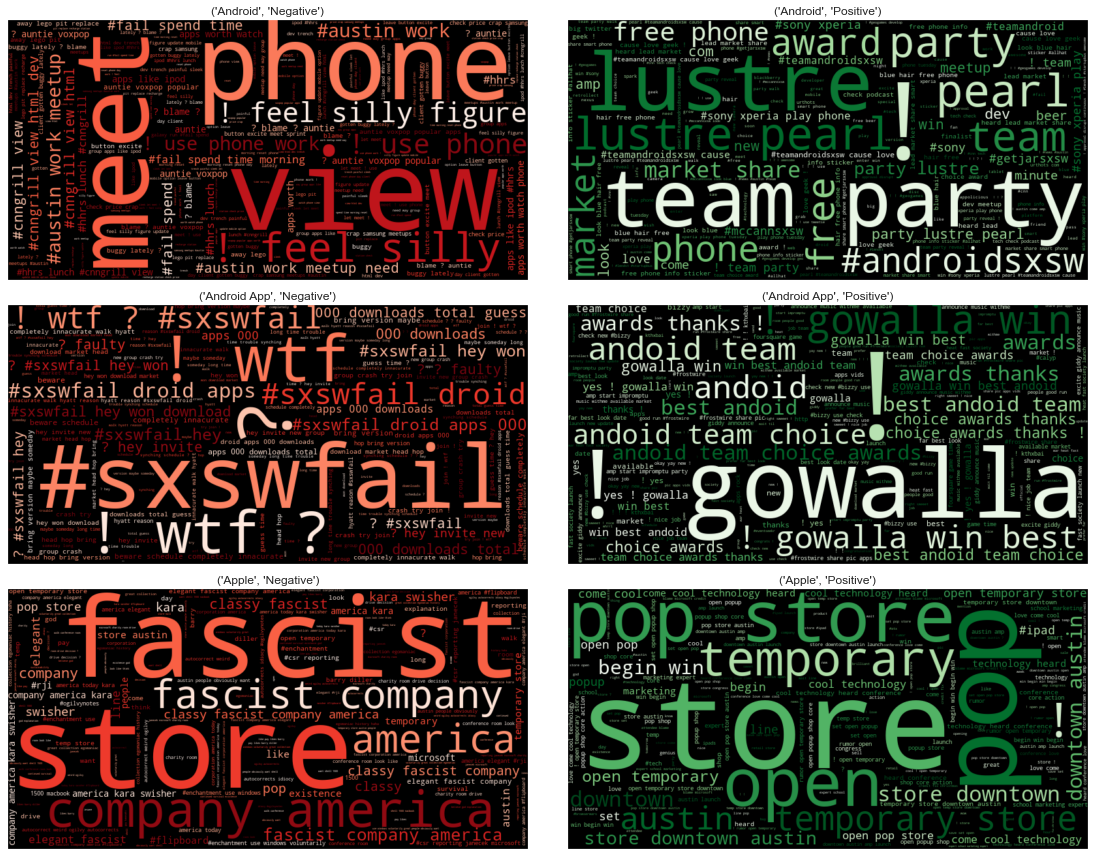

<IPython.core.display.Javascript object>

In [173]:
fig = plotting.wordcloud(
    pair_vecs.iloc[:, :6],
    cmap=["Reds", "Greens"] * 9,
    size=(8, 4),
    ncols=2,
    random_state=rando,
)

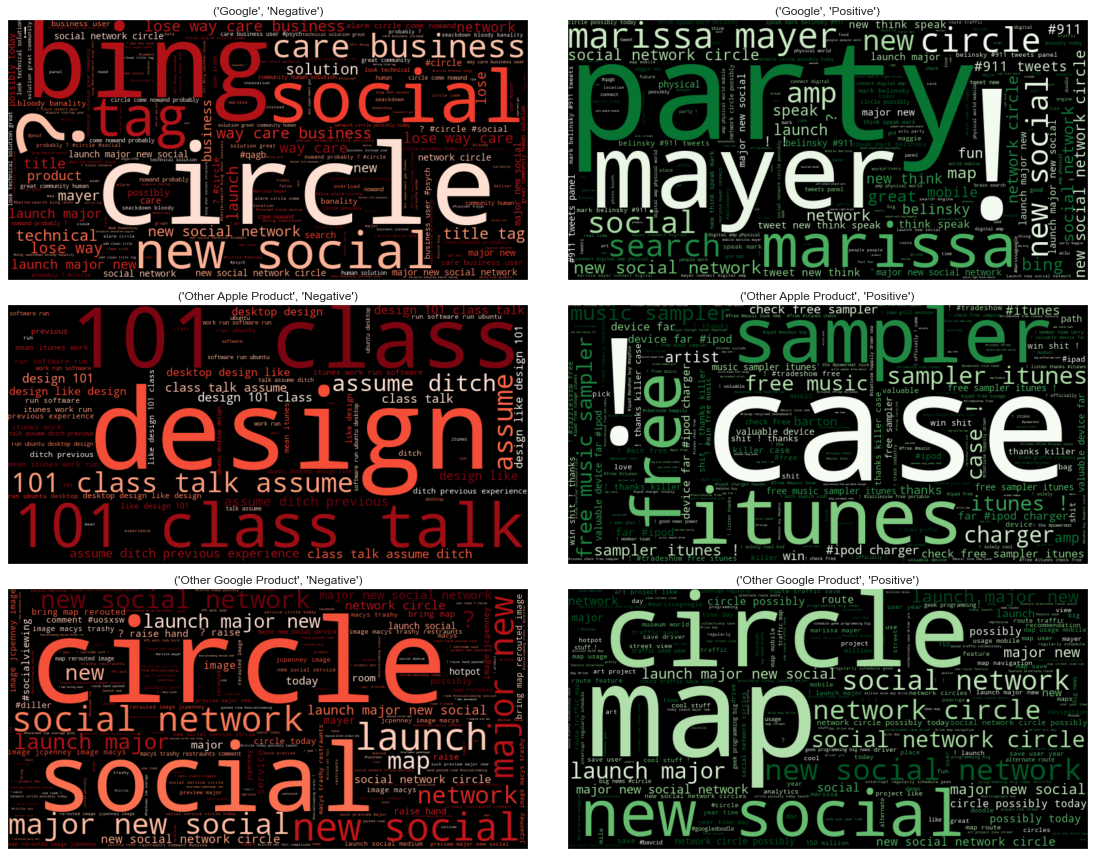

<IPython.core.display.Javascript object>

In [174]:
fig = plotting.wordcloud(
    pair_vecs.iloc[:, 6:12],
    cmap=["Reds", "Greens"] * 9,
    size=(8, 4),
    ncols=2,
    random_state=rando,
)

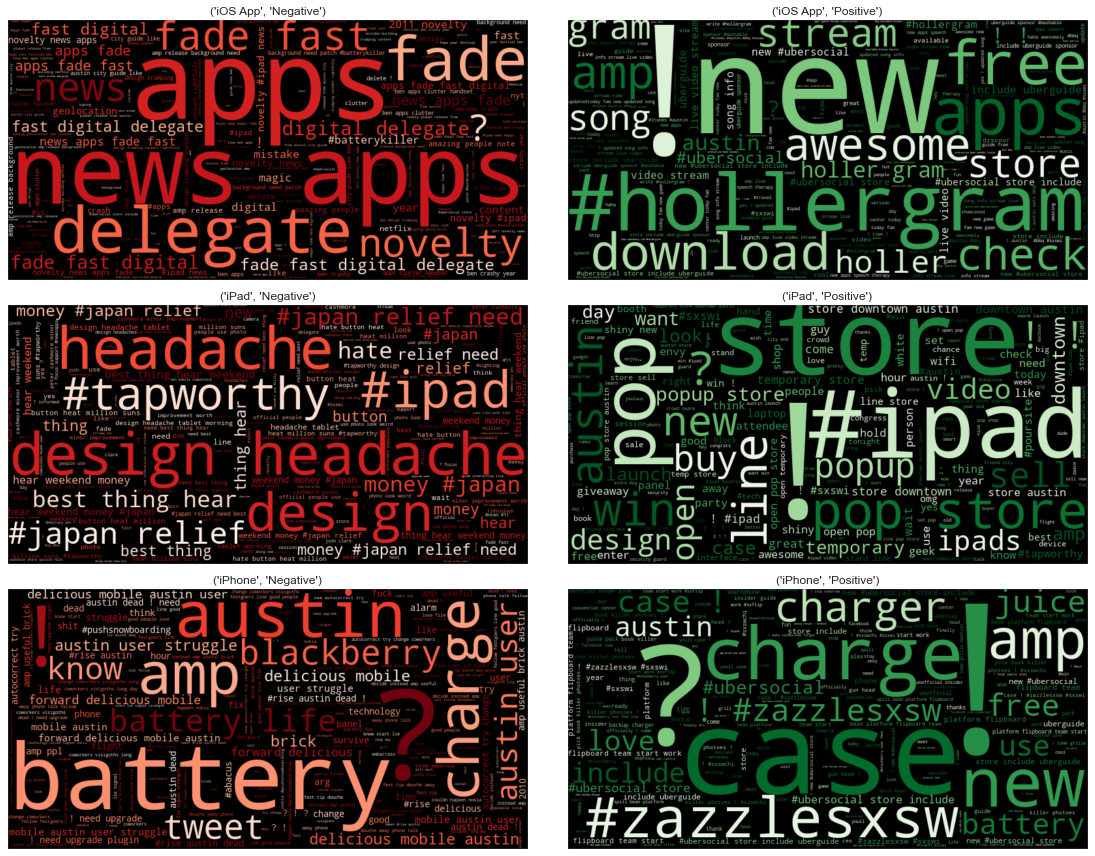

<IPython.core.display.Javascript object>

In [175]:
fig = plotting.wordcloud(
    pair_vecs.iloc[:, 12:],
    cmap=["Reds", "Greens"] * 9,
    size=(8, 4),
    ncols=2,
    random_state=rando,
)

# Modeling

In [50]:
df["pos_tags"] = df["pos_tags"].str.join(" ")
df["pos_tags"].head()

0    . NN PRP VBP DT CD NN . IN CD NN NN IN NNP , P...
1    NN NNP IN NNP . NNP NN NNP NN NN WDT VBZ JJ NN...
2    NNS MD RB VB IN JJ CD RB . PRP MD NN PRP RP IN...
3     NN PRP VBP DT NN NN NN RB JJ IN DT NN NN NN . NN
4    JJ JJ NN IN NNP NN : NNP NNP ( NNP ) , NNP NNP...
Name: pos_tags, dtype: object

<IPython.core.display.Javascript object>

In [51]:
df["brand_terms"] = utils.implode(
    df["brand_terms"].explode().str.replace(" ", "_").fillna("")
)
df["brand_terms"] = df["brand_terms"].str.join(" ")
df["brand_terms"].head()

0             iphone
1    ipad iphone_app
2               ipad
3         iphone_app
4             google
Name: brand_terms, dtype: object

<IPython.core.display.Javascript object>

## Train-Test-Split

In [52]:
cols = [
    "text",
    "pos_tags",
    "brand_terms",
]
X = df.loc[:, cols].copy()
y = df.emotion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=rando,
    stratify=y,
    shuffle=True,
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6659, 3), (6659,), (2220, 3), (2220,))

<IPython.core.display.Javascript object>

## Baseline Dummy Model

In [53]:
col_xform = ColumnTransformer(
    [
        ("txt", TfidfVectorizer(tokenizer=nltk.casual_tokenize), "text"),
        (
            "pos",
            TfidfVectorizer(tokenizer=lang.space_tokenize, lowercase=False),
            "pos_tags",
        ),
        ("bra", TfidfVectorizer(tokenizer=lang.space_tokenize), "brand_terms"),
    ],
    n_jobs=1,
)
col_xform

ColumnTransformer(n_jobs=1,
                  transformers=[('txt',
                                 TfidfVectorizer(tokenizer=<function casual_tokenize at 0x000001CA2C636E50>),
                                 'text'),
                                ('pos',
                                 TfidfVectorizer(lowercase=False,
                                                 tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                 'pos_tags'),
                                ('bra',
                                 TfidfVectorizer(tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                 'brand_terms')])

<IPython.core.display.Javascript object>

In [54]:
main_pipe = Pipeline(
    [
        ("col", col_xform),
        ("cls", DummyClassifier(strategy="stratified", random_state=rando)),
    ]
)
main_pipe

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(tokenizer=<function casual_tokenize at 0x000001CA2C636E50>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                                  'brand_terms')])),
                ('cls',
                 DummyClassifier(random_state=RandomState(MT19937) at 0x1CA31A8F240

<IPython.core.display.Javascript object>

In [55]:
vecs = main_pipe[:1].fit_transform(X)
vecs

<8879x10641 sparse matrix of type '<class 'numpy.float64'>'
	with 283829 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [56]:
vecs.todense()

matrix([[0.08833442, 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.90013706,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.20527898, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

<IPython.core.display.Javascript object>

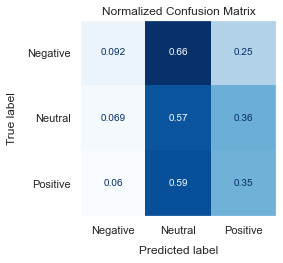

<IPython.core.display.Javascript object>

In [57]:
test_fit = partial(
    diag.test_fit,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
test_fit(main_pipe)

## Baseline Model

In [58]:
logit = LogisticRegression(
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1e4,
    verbose=0,
    random_state=rando,
)
logit

LogisticRegression(class_weight='balanced', max_iter=10000.0,
                   multi_class='multinomial',
                   random_state=RandomState(MT19937) at 0x1CA31A8F240)

<IPython.core.display.Javascript object>

In [59]:
main_pipe.set_params(cls=logit)

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(tokenizer=<function casual_tokenize at 0x000001CA2C636E50>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                                  'brand_terms')])),
                ('cls',
                 LogisticRegression(class_weight='balanced', max_iter=10000.0,
    

<IPython.core.display.Javascript object>

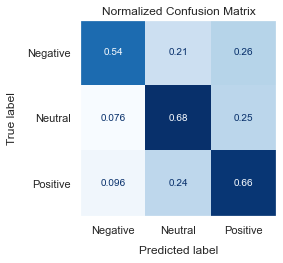

<IPython.core.display.Javascript object>

In [60]:
test_fit(main_pipe)

## Model Mark II

In [61]:
run_sweep = partial(
    sweep,
    X=X,
    y=y,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(),
    random_state=46,
)

<IPython.core.display.Javascript object>

### Select Tokenizer

In [62]:
grid = pd.Series(
    dict(
        tokenizer=[
            nltk.casual_tokenize,
            nltk.word_tokenize,
            nltk.wordpunct_tokenize,
            lang.space_tokenize,
            TreebankWordTokenizer().tokenize,
            NLTKWordTokenizer().tokenize,
            None,
        ]
    )
)

# run_sweep(
#     main_pipe,
#     grid.add_prefix("col__txt__"),
#     dst="sweeps/tokenizer",
#     kind="grid",
# )

<IPython.core.display.Javascript object>

In [63]:
results = load_results("sweeps/tokenizer.joblib")
results.tokenizer = results.tokenizer.map(str).map(lang.strip_punct)
results.style.bar("mean_score")

<IPython.core.display.Javascript object>

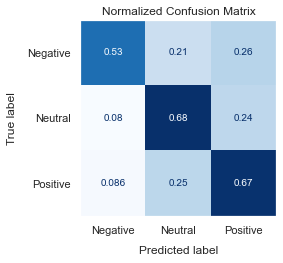

<IPython.core.display.Javascript object>

In [64]:
main_pipe.set_params(col__txt__tokenizer=nltk.wordpunct_tokenize)
test_fit(main_pipe)

### Optimize Punctuation Filter

In [65]:
# List of every punctuation mark, plus empty
keepers_to_try = list(string.punctuation) + [""]

# Try excluding each, individually
grid = dict(
    col__txt__preprocessor=[
        partial(lang.strip_punct, exclude=x) for x in keepers_to_try
    ]
)

del keepers_to_try

# run_sweep(main_pipe, grid, dst="sweeps/punctuation", kind="grid")

<IPython.core.display.Javascript object>

'!' and '?' are the two punctuation marks that really stand out. There are many others which are above the baseline None, but not significantly enough for me to exclude them (excluding too many makes the filter perform worse overall). It's interesting that '@' and '#' score below the baseline, indicating that these seemingly important Twitter symbols are actually noise where the model is concerned.

In [66]:
results = load_results("sweeps/punctuation")
results["preprocessor"] = (
    results["preprocessor"]
    .map(attrgetter("keywords"))
    .map(itemgetter("exclude"))
    .replace("", "None")
)
results.rename({"preprocessor": "retained_in_text"}, axis=1, inplace=True)
results.set_index("retained_in_text", inplace=True)
results.style.bar("mean_score")

<IPython.core.display.Javascript object>

### Select Filters

In [67]:
funcs = funcs.drop("strip_punct")
funcs["strip_punct"] = partial(lang.strip_punct, exclude="!?'<")
funcs

lowercase                    <function lowercase at 0x000001CA308F3790>
strip_short                <function strip_short at 0x000001CA308F3820>
strip_multiwhite      <function strip_multiwhite at 0x000001CA308F38B0>
strip_numeric            <function strip_numeric at 0x000001CA308F3940>
strip_non_alphanum    <function strip_non_alphanum at 0x000001CA308F...
split_alphanum          <function split_alphanum at 0x000001CA308F3A60>
uni2ascii                    <function uni2ascii at 0x000001CA308F60D0>
stem_text                    <function stem_text at 0x000001CA308F3E50>
strip_handles            <function strip_handles at 0x000001CA308F3EE0>
limit_repeats            <function limit_repeats at 0x000001CA308F3AF0>
wordnet_lemmatize     <function wordnet_lemmatize at 0x000001CA308FA...
mark_pos                      <function mark_pos at 0x000001CA308FA4C0>
mark_negation            <function mark_negation at 0x000001CA308FA820>
strip_punct           functools.partial(<function strip_punct at

<IPython.core.display.Javascript object>

In [68]:
# All preprocessing funcs plus None
grid = dict(col__txt__preprocessor=funcs.to_list() + [None])

# Turn off lowercasing to test its effectiveness
main_pipe.set_params(col__txt__lowercase=False)

# run_sweep(main_pipe, grid, dst="sweeps/filters", kind="grid")

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x

<IPython.core.display.Javascript object>

In [69]:
results = load_results("sweeps/filters")
results["preprocessor"] = results["preprocessor"].map(utils.get_func_name, "ignore")
results.style.bar("mean_score")

<IPython.core.display.Javascript object>

I include the top scorers and some others which are compatible and above the baseline.

In [70]:
text_pp = lang.make_preprocessor(
    [
        lang.lowercase,
        lang.strip_handles,
        lang.uni2ascii,
        lang.wordnet_lemmatize,
        lang.mark_negation,
        partial(lang.strip_punct, exclude="!?'<"),
        lang.limit_repeats,
    ],
)


text_pp(df.text.head(10))

0       i have a 3g iphone  after 3 hr tweet at  ris...
1     know about? awesome ipad iphone app that you'l...
2     cannot wait<<NEG for<<NEG  <<NEG ipad<<NEG 2<<...
3     i hope this year's festival ben't as<<NEG cras...
4     great stuff on fri  sxsw  marissa mayer  googl...
5     new ipad apps for  speechtherapy and communica...
7      sxsw be just start   ctia be around the corne...
8     beautifully smart and simple idea rt write abo...
9     count down the day to  sxsw plus strong canadi...
10    excite to meet the at  sxsw so i can show them...
Name: text, dtype: object

<IPython.core.display.Javascript object>

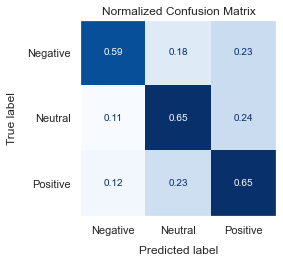

<IPython.core.display.Javascript object>

In [71]:
main_pipe.set_params(col__txt__preprocessor=text_pp)
test_fit(main_pipe)

### Select Stopwords

In [72]:
nltk_stop = nltk.corpus.stopwords.words("english")
gensim_stop = list(STOPWORDS)
my_stop = my_stop
nltk_stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

<IPython.core.display.Javascript object>

In [73]:
grid = dict(
    col__txt__stop_words=[
        gensim_stop,
        nltk_stop,
        my_stop,
        "english",
        None,
    ]
)

# run_sweep(
#     main_pipe,
#     grid,
#     dst="sweeps/stop_words",
# )

<IPython.core.display.Javascript object>

In [74]:
results = load_results("sweeps/stop_words")
results

stop_words  mean_score  rank_score
4                                               None    0.636333           1
1  [i, me, my, myself, we, our, ours, ourselves, ...    0.634471           2
2                          [sxsw, #sxsw, quot, link]    0.633908           3
0  (behind, he, nine, alone, whence, whose, may, ...    0.627356           4
3                                            english    0.625652           5

<IPython.core.display.Javascript object>

### Select N-Gram Range

In [75]:
grid = dict(col__txt__ngram_range=utils.cartesian(1, np.arange(1, 4)).tolist())
# run_sweep(main_pipe, grid, dst="sweeps/text_ngrams")

<IPython.core.display.Javascript object>

In [76]:
load_results("sweeps/text_ngrams").style.bar("mean_score")

<IPython.core.display.Javascript object>

## Model Mark III

### Test Binary Term Frequencies

In [77]:
grid = pd.Series(dict(binary=[True, False]))
grid = pd.concat(
    [
        grid.add_prefix("col__txt__"),
        grid.add_prefix("col__pos__"),
        grid.add_prefix("col__bra__"),
    ],
    axis=0,
)
# run_sweep(main_pipe, grid, dst="sweeps/binary_tf")

<IPython.core.display.Javascript object>

In [78]:
load_results("sweeps/binary_tf", short_names=False).style.bar("mean_test_score")

<IPython.core.display.Javascript object>

### Add VADER Vectorizer

In [79]:
col_xform.transformers.append(("vad", VaderVectorizer(), "text"))
col_xform

ColumnTransformer(n_jobs=1,
                  transformers=[('txt',
                                 TfidfVectorizer(lowercase=False,
                                                 preprocessor=functools.partial(<function chain_funcs at 0x000001CA308F6B80>, funcs=[<function lowercase at 0x000001CA308F3790>, <function strip_handles at 0x000001CA308F3EE0>, <function uni2ascii at 0x000001CA308F60D0>, <function wordnet_lemmatize at 0x000001CA308FAC10>, <function mark_nega...
                                                 tokenizer=<bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>),
                                 'text'),
                                ('pos',
                                 TfidfVectorizer(lowercase=False,
                                                 tokenizer=<function space_tokenize at 0x000001CA308F6DC0>),
                                 'pos_tags

<IPython.core.display.Javascript object>

Looks like a sizable ~0.01 increase in balanced accuracy by just adding 4 new features.

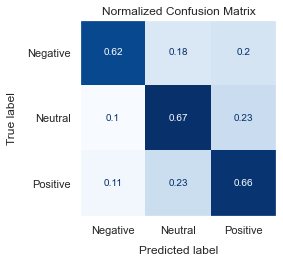

<IPython.core.display.Javascript object>

In [80]:
main_pipe.set_params(col__vad__trinarize=True)
test_fit(main_pipe)

In [81]:
grid = dict(col__vad__preprocessor=funcs.to_list() + [None])
# run_sweep(main_pipe, grid, dst="sweeps/vader_pp")

<IPython.core.display.Javascript object>

I set leave the preprocessing off, because nothing stands out as markedly superior to the baseline. I also know that VADER accounts for things such as case.

In [82]:
results = load_results("sweeps/vader_pp")
results.preprocessor = results.preprocessor.map(utils.get_func_name, "ignore")
results.style.bar("mean_score")

<IPython.core.display.Javascript object>

In [83]:
grid = dict(col__vad__trinarize=[True, False])
# run_sweep(main_pipe, grid, dst="sweeps/vader_trinarize")

<IPython.core.display.Javascript object>

In [84]:
load_results("sweeps/vader_trinarize")

trinarize  mean_score  rank_score
1     False    0.651277           1
0      True    0.650702           2

<IPython.core.display.Javascript object>

Well, my accuracy decreased for the current split. But the balanced accuracy varies widely between splits, and the GridSearchCV results are 5-fold cross-validated.

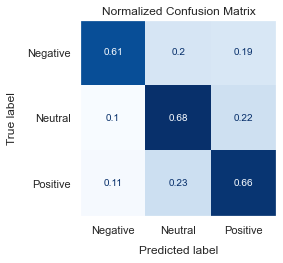

<IPython.core.display.Javascript object>

In [85]:
main_pipe.set_params(col__vad__trinarize=False)
test_fit(main_pipe)

## Model Mark IV

In [86]:
grid = (
    pd.Series(col_xform.named_transformers_)
    .map(lambda x: [x, "drop"])
    .add_prefix("col__")
)
grid
# run_sweep(main_pipe, grid, dst="sweeps/drop_xformer")}

col__txt    [TfidfVectorizer(lowercase=False,\n           ...
col__pos    [TfidfVectorizer(lowercase=False,\n           ...
col__bra    [TfidfVectorizer(tokenizer=<function space_tok...
col__vad                            [VaderVectorizer(), drop]
dtype: object

<IPython.core.display.Javascript object>

In [87]:
load_results("sweeps/drop_xformer").head().style.bar("mean_score")

<IPython.core.display.Javascript object>

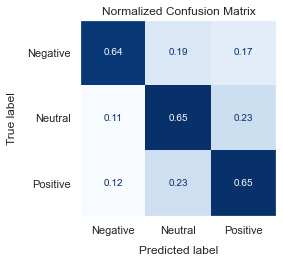

<IPython.core.display.Javascript object>

In [88]:
main_pipe.set_params(col__pos="drop")
test_fit(main_pipe)

In [89]:
grid = dict(cls__C=np.geomspace(1e-4, 1e4, 9))

run_sweep(main_pipe, grid, dst="sweeps/penalty")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


'sweeps\\penalty.joblib'

<IPython.core.display.Javascript object>

In [90]:
load_results("sweeps/penalty").style.bar("mean_score")

<IPython.core.display.Javascript object>

In [91]:
main_pipe.fit(X, y)

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(lowercase=False,
                                                                  preprocessor=functools.partial(<function chain_funcs at 0x000001CA308F6B80>, funcs=[<function lowercase at 0x000001CA308F3790>, <function strip_handles at 0x000001CA308F3EE0>, <function uni2ascii at 0x000001CA308F60D0>, <function wordnet_lemmatize at 0x000001CA308FA...
                                                                  tokenizer=<bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>),
                                                  'text'),
                                                 ('pos', 'drop', 'pos_tags'),
                                                 ('bra',
                     

<IPython.core.display.Javascript object>

In [92]:
feat_names = col_xform.get_feature_names()
classes = main_pipe["cls"].classes_
coef = pd.DataFrame(main_pipe["cls"].coef_, columns=feat_names, index=classes).T
coef.sort_values("Negative").filter(like="bra_", axis=0)

Negative   Neutral  Positive
bra__            -2.031161  2.447574 -0.416412
bra__ipad_app    -0.648733  0.065956  0.582777
bra__android     -0.243165  0.028797  0.214369
bra__android_app -0.170161 -0.297711  0.467872
bra__apple       -0.130765 -0.325975  0.456740
bra__google      -0.115919 -0.042334  0.158252
bra__ipad        -0.093294 -0.356130  0.449424
bra__iphoneapp   -0.061951  0.148081 -0.086130
bra__iphone_app   0.084098 -0.464815  0.380717
bra__iphone       0.378401 -0.373139 -0.005262

<IPython.core.display.Javascript object>

In [93]:
coef.filter(like="txt", axis=0)

Negative   Neutral  Positive
txt__!          -1.373077 -1.385216  2.758293
txt__!!         -0.516849 -0.514096  1.030945
txt__!!!        -0.335782 -1.375775  1.711557
txt__!?         -0.204248 -0.112558  0.316806
txt__!?!?        0.527495 -0.253336 -0.274159
...                   ...       ...       ...
txt__zone        0.716800 -0.248681 -0.468119
txt__zoom       -0.061949 -0.122407  0.184356
txt__zuckerberg -0.030540  0.127203 -0.096663
txt__zynga      -0.058980  0.207467 -0.148487
txt__zzzs        0.341506 -0.155147 -0.186359

[8530 rows x 3 columns]

<IPython.core.display.Javascript object>

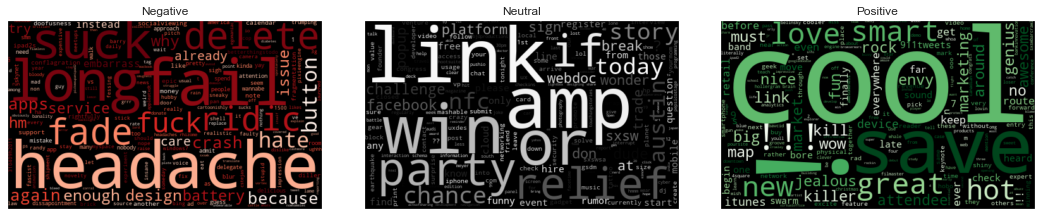

<IPython.core.display.Javascript object>

In [94]:
text_coef = coef.filter(like="txt", axis=0)
text_coef.index = text_coef.index.str.replace("txt__", "")

fig = plotting.wordclouds.wordcloud(
    text_coef, cmap=dict(Negative="Reds", Neutral="Greys", Positive="Greens")
)